## Machine learning project final version

Author: Gérard Lichtert

Student id: 0557513

First we import some necessary libraries & define functions required for making predictions and saving them to a csv. This code is taken from notebooks provided with the assignment.


In [1]:
# numerical library: 
import numpy as np

# data manipulation library:
import pandas as pd

# standard packages used to handle files:
import sys
import os 
import glob
import time

# scikit-learn machine learning library:
import sklearn

# plotting:
import matplotlib.pyplot as plt
import seaborn as sns  

# tell matplotlib that we plot in a notebook:
%matplotlib inline

#snippet taken from project documents

In [2]:
#snippet taken from project documents

def generate_unique_filename(basename, file_ext):
    """Adds a timestamp to filenames for easier tracking of submissions, models, etc."""
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    return basename + '_' + timestamp + '.' + file_ext



In [3]:
#snippet taken from project documents
 
data_folder = "../updated_data/"

train_data = pd.read_csv(data_folder + "train.csv")
test_data = pd.read_csv(data_folder + "test.csv")

## 1. Data exploration

First we will start by exploring the given data. 

Our goal is to build a regression model that predicts the count of E-scooters as well as possible based on the given data. Examples consist of 14 attributes namely: 

* Date
* Hour
* Temperature
* Humidity
* Wind speed
* Visibility
* Dew point temperature
* Solar radiation
* Rainfall
* Snowfall
* Seasons
* Holiday
* Functioning day
* Count of E-scooters

Where the count of E-scooters will be the target value during the training of the model(s). This means that this is not a classification problem but a regression problem since its values are continuous. 

We notice that the training set consists of 5000 entries and that each entry has 13 attributes + 1 target value. Below we can see the first few entries and their attributes. 


In [4]:
# capturing dimensions of the training data

#amount of examples
training_examples = len(train_data.index)
#amount of attributes in an example
data_attributes = len(train_data.columns)
print(f"Number of rows: {training_examples}")
print(f'Number of attributes: {data_attributes}')


#visualizes first few examples
train_data.head()

Number of rows: 5000
Number of attributes: 14


,Date,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,E-scooter Count
0,07/10/2018,22,13.6,38,1.5,2000,-0.4,0.00,0.0,0.0,Autumn,No Holiday,Yes,1160
1,04/02/2018,0,-10.4,49,2.4,2000,-19.0,0.00,0.0,0.0,Winter,No Holiday,Yes,98
2,31/07/2018,20,33.5,50,2.1,2000,21.6,0.04,0.0,0.0,Summer,No Holiday,Yes,1772
3,15/09/2018,0,21.8,83,1.5,2000,18.7,0.00,0.0,0.0,Autumn,No Holiday,Yes,906
4,10/03/2018,6,1.1,78,1.1,538,-2.3,0.00,0.0,0.0,Spring,No Holiday,Yes,74


Next we want to visualize our training data to see what it looks like and analyze it. 

First we change the values of the attributes: "Seasons, Holiday and Functioning Day" to numeric values so we can display it properly

We'll represent Spring as 0, Summer as 1, Autumn as 2 and Winter as 3
The holiday we'll be representing the Holiday attribute as a binary value (0 if there is no holiday and 1 if there is.)
We'll be representing Functioning day attribute the same way as the holiday attribute. (0 if it isn't a Functioning day and 1 if it is.) 

In [5]:
# To enumerate our data we replace string values with integer values. 

training_data_numerated = train_data.replace(to_replace="Spring", value=0)
del training_data_numerated['Date']
# We remove the Date column to make visualization easier since it isn't plotted anyways. 
training_data_numerated.replace(to_replace="Summer", value=1, inplace=True)
training_data_numerated.replace(to_replace="Autumn", value=2, inplace=True)
training_data_numerated.replace(to_replace="Winter", value=3, inplace=True)
training_data_numerated.replace(to_replace="No Holiday", value=0, inplace=True)
training_data_numerated.replace(to_replace="Holiday", value=1, inplace=True)
training_data_numerated.replace(to_replace="No", value=0, inplace=True)
training_data_numerated.replace(to_replace="Yes", value=1, inplace=True)
training_data_numerated.head()


,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,E-scooter Count
0,22,13.6,38,1.5,2000,-0.4,0.00,0.0,0.0,2,0,1,1160
1,0,-10.4,49,2.4,2000,-19.0,0.00,0.0,0.0,3,0,1,98
2,20,33.5,50,2.1,2000,21.6,0.04,0.0,0.0,1,0,1,1772
3,0,21.8,83,1.5,2000,18.7,0.00,0.0,0.0,2,0,1,906
4,6,1.1,78,1.1,538,-2.3,0.00,0.0,0.0,0,0,1,74


Now we can visualize the training data. 

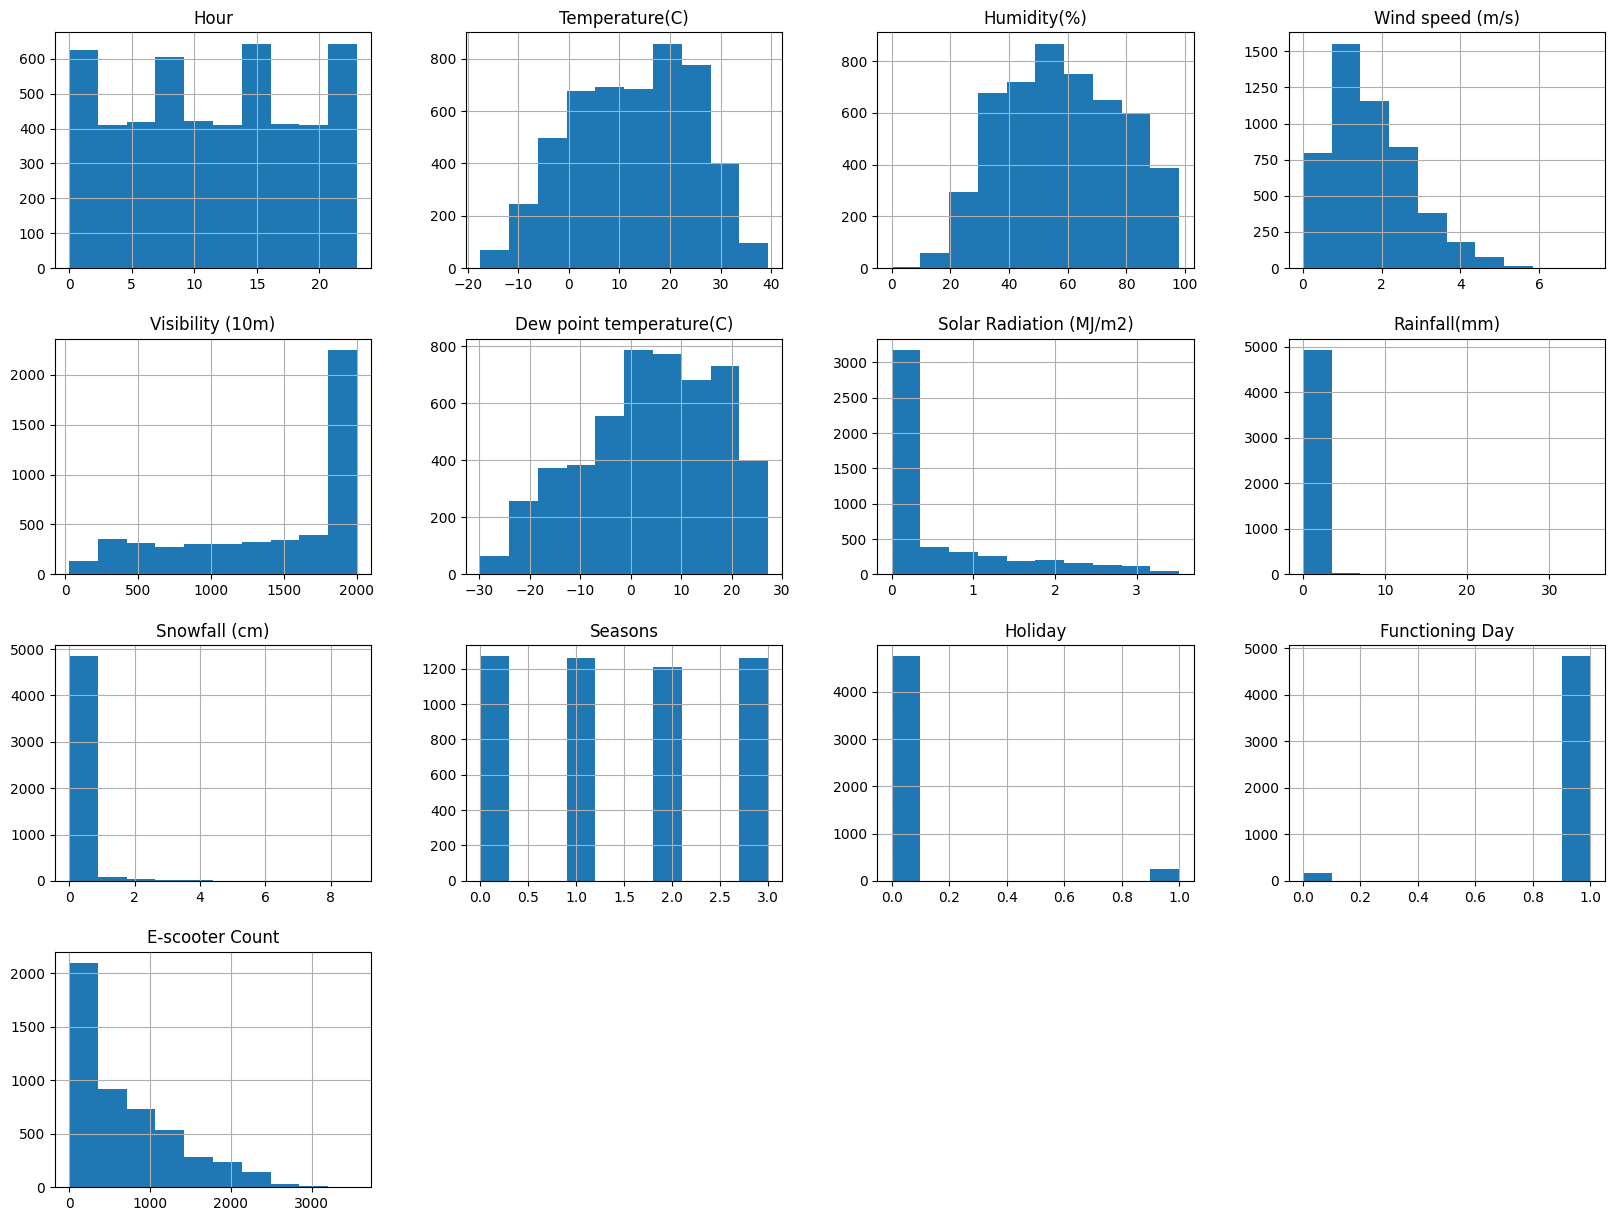

In [6]:
training_data_numerated.hist(figsize=(20,15))
plt.show()

#### What can we tell from these histograms? 

Some values of attributes are divided up nicely but some aren't. For example: We have a lot more data points for Holiday attribute when there isn't one than when there is. However we don't see a direct correlation with the target values. 

Something that we do notice is that there is a direct correlation between the functioning day value and the target value. Whenever there is not a functioning day the target value is always 0. 

Furthermore we can see that some attributes have long tails but we will be ignoring this for now.


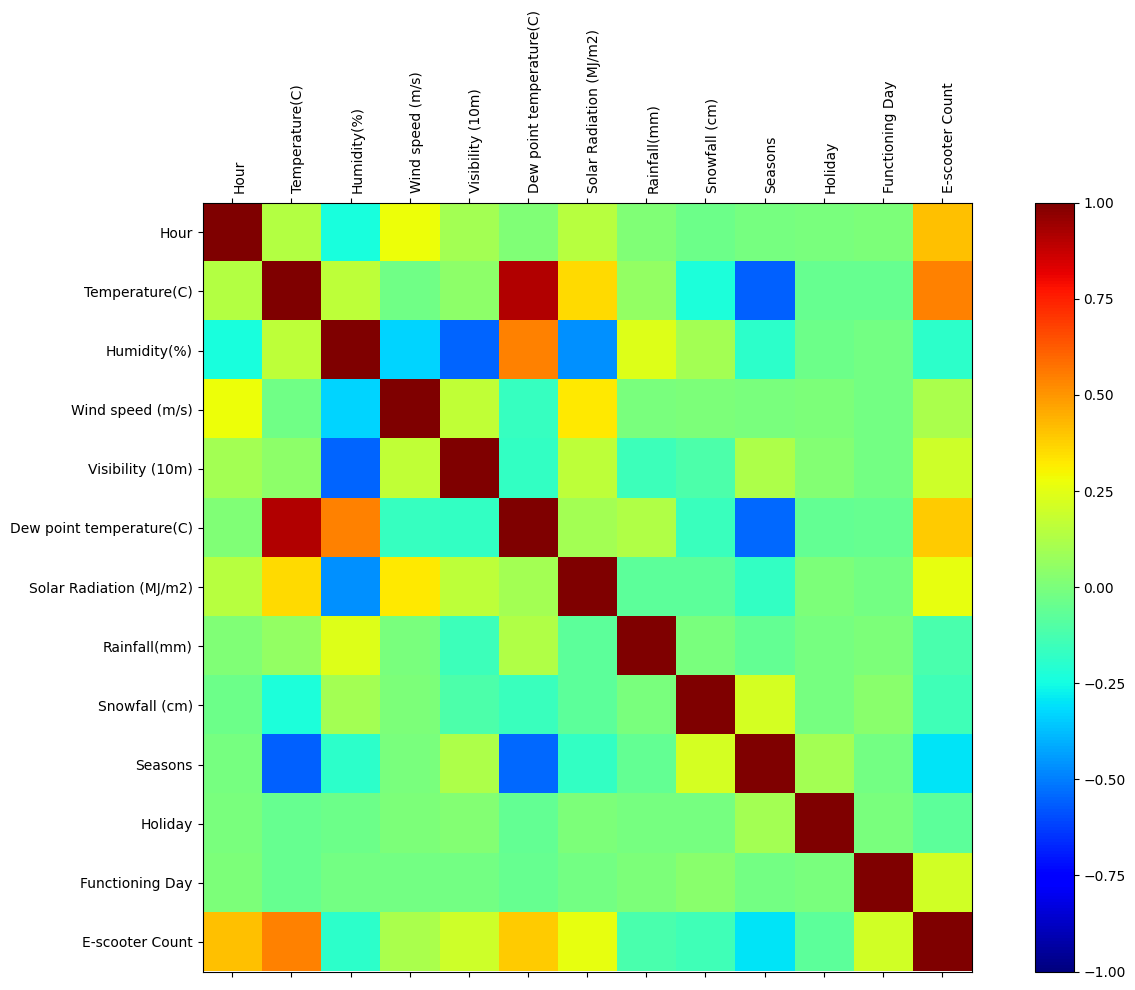

In [7]:
#snippet taken from project documents

def plot_correlation_matrix(df):
    """Takes a pandas dataframe as input"""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,10))
    plt.jet() # set the colormap to jet
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1)

    ticks = list(range(len(df.columns)))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.set_xticklabels(df.columns, rotation=90, horizontalalignment='left')
    ax.set_yticklabels(df.columns)
    
    fig.colorbar(cax, ticks=[-1.0,-0.75,-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])

    plt.tight_layout()
    plt.show()
    
plot_correlation_matrix(training_data_numerated)


#### What can we tell from this correlation matrix?

We see that while there are mostly uncorrelated attributes there are some who are highly correlated such as the hour and the count, or the temperature and dew point temperature. Which are both positively correlated. Other heavily correlated pairs seem to be the Seasons with Temperature and Dew point temperature. Humidity with Wind speed, Visibility and Solar Radiation which are all negatively correlated. 

We can also see that there is a moderate correlation between the E-scooter Count and the Hour, Humidity, Dew point temperature and Seasons. This could mean that these features will perform well with a linear model. 

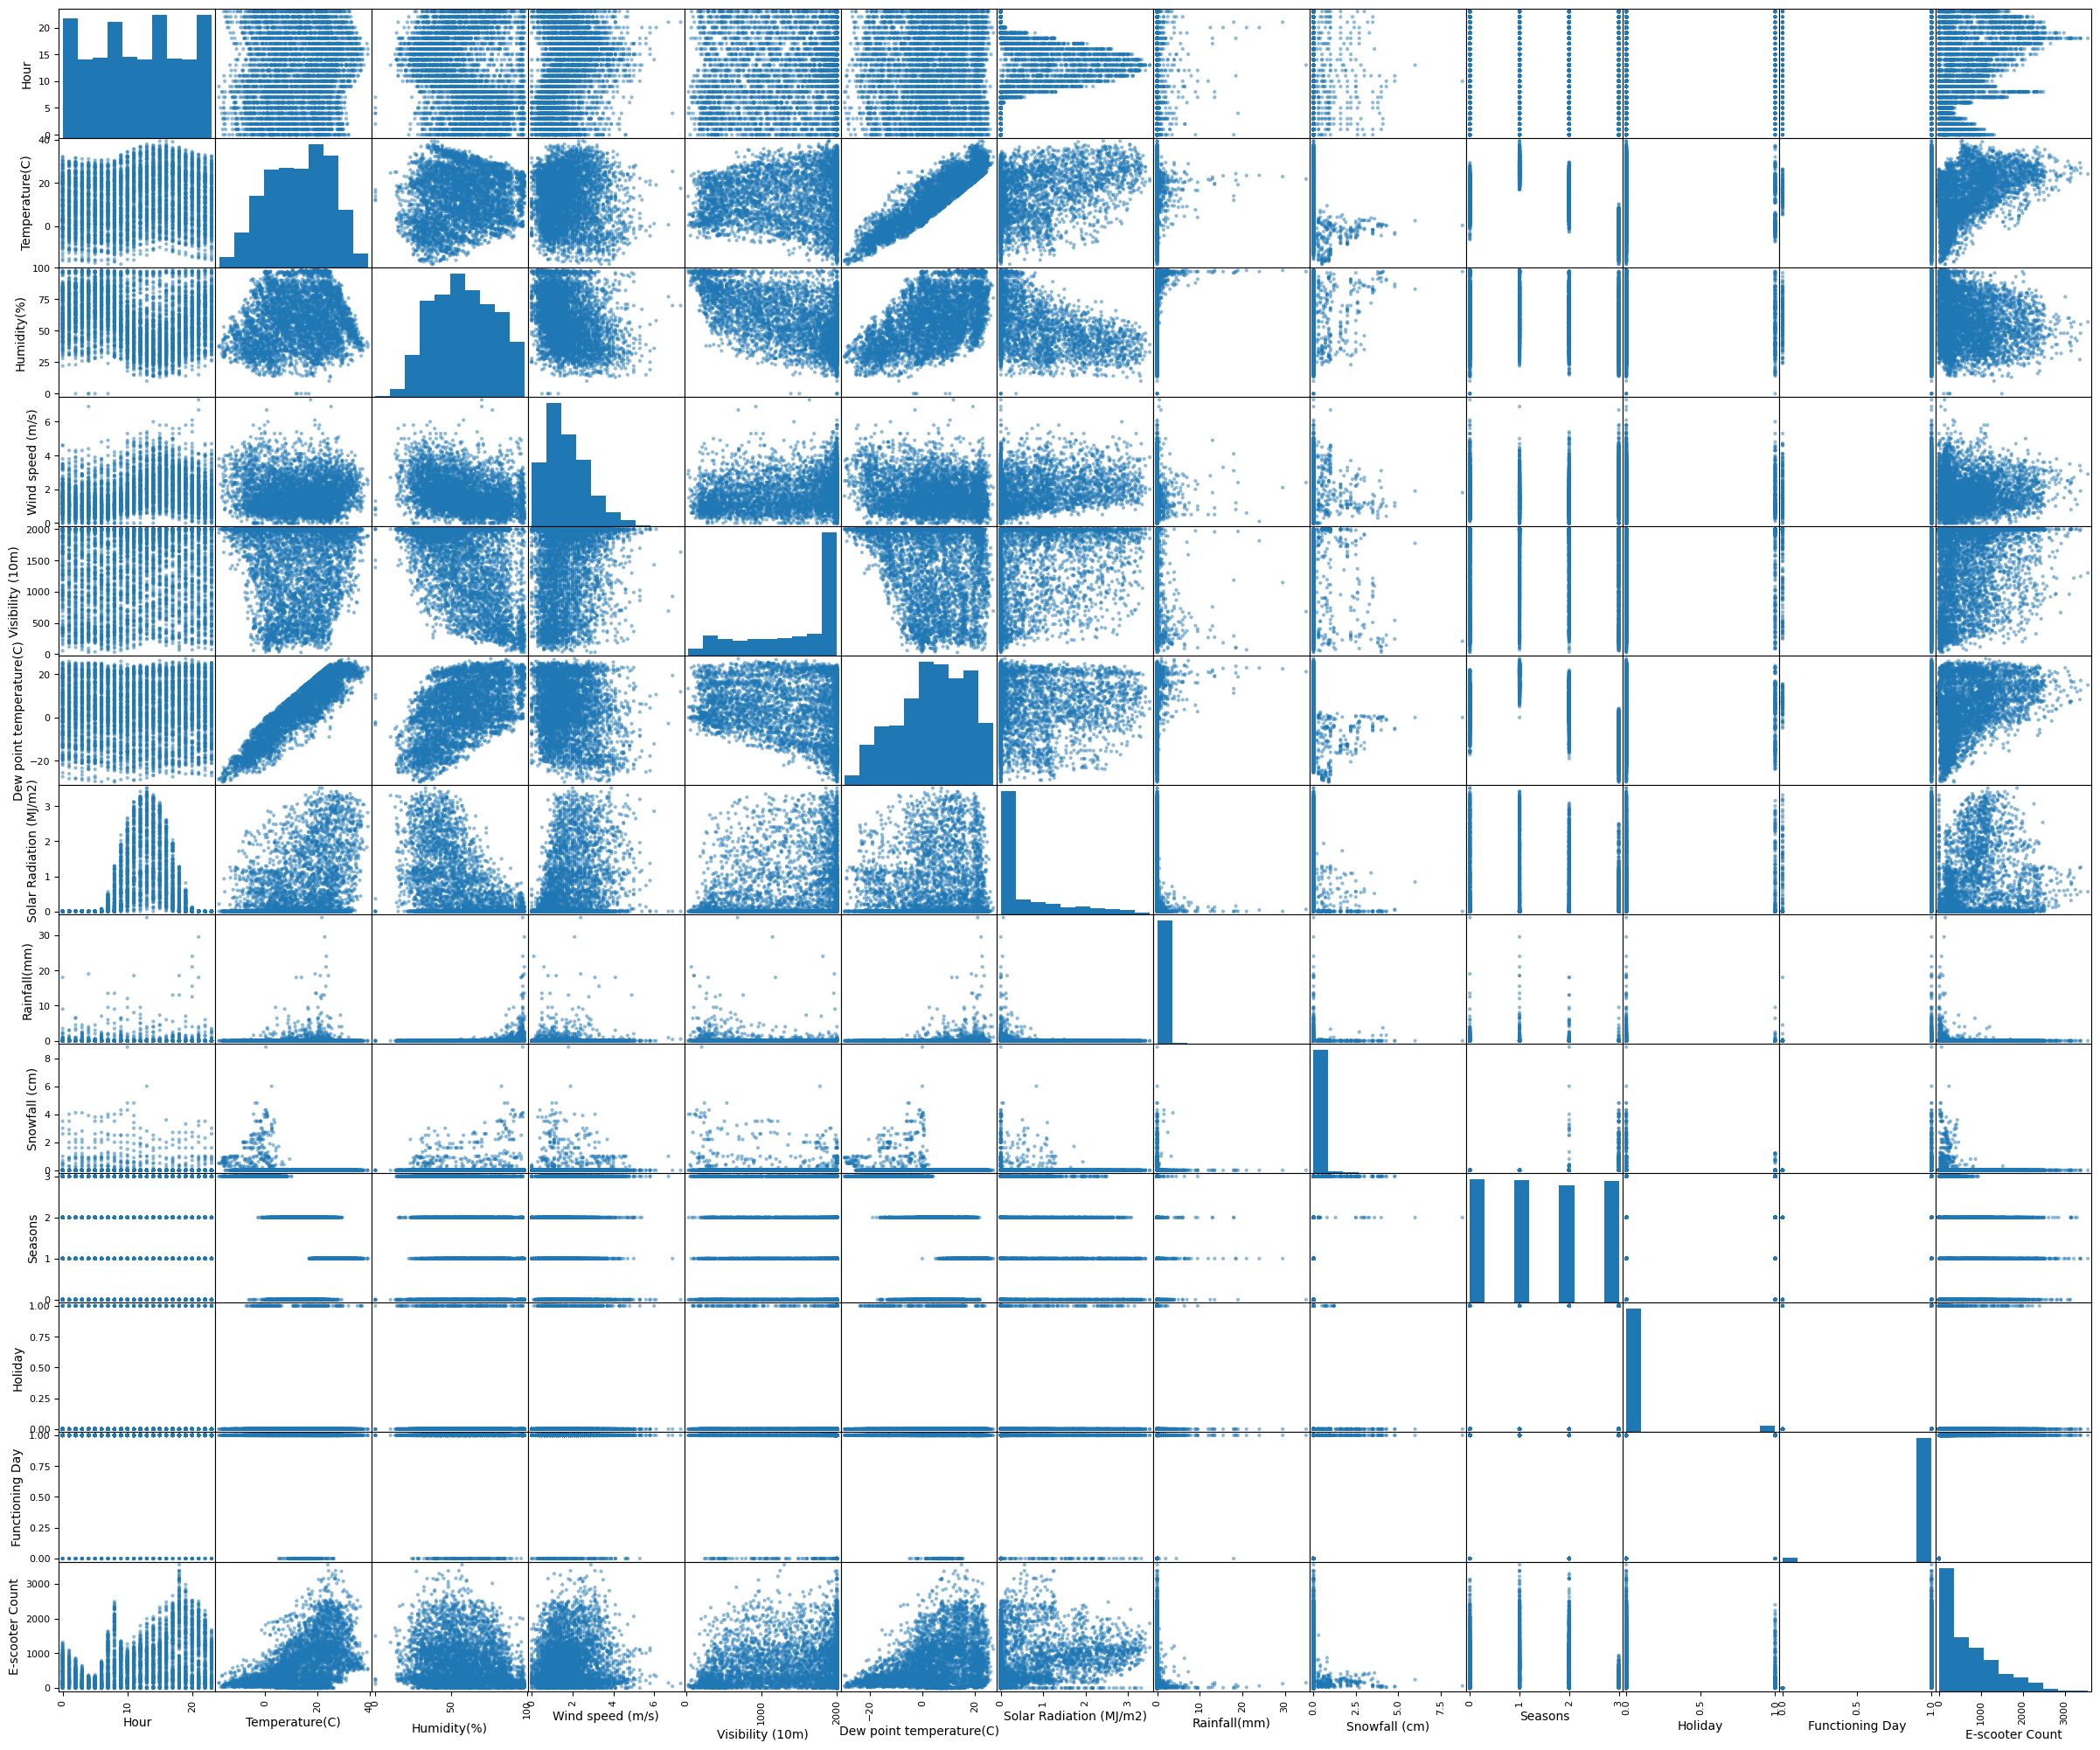

In [8]:
# Snippet taken from project documents
from pandas.plotting import scatter_matrix
scatter_matrix(training_data_numerated,figsize = (30,25))
plt.show()

#### What can we tell from this scatter matrix?

We can visually predict some indicators of higher counts of E-scooters. Such as that there probably will be a higher count of E-scooters when the wind speed is low. There probably will be more E-scooters when the temperature is higher, and so on...

## 2. Preprocessing

As mentioned before we'll be removing the Date feature. I'm doing this because I feel like it won't add value to my model since it's just the date when the entry was saved and the value won't be repeated in the future. However perhaps special holiday dates might influence the model. Nonetheless I feel like relationships between special days or peaks during certain hours of the day will already be captured by the "Hour" and "Holiday" feature. Another reason is because it makes the data easier to work with. 

Upon inspecting the training data I noticed that there weren't any unknown values. 

For now we ignore the outliers and turn the categorical features into numerical features (as done during the Data exploration).

## 3. Model selection and tuning

Models that I considered are:
* Linear models 
* Decision trees
* Neural Networks
* Ensemble models



## 4. My results

## 5. Analysis